# Task 1: Sampling and Quantization Techniques

In [31]:
# importing all necessary packages
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as signal
from scipy.interpolate import interp1d

import librosa

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [32]:
# step 1: load the audio file and convering it into mono
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    return audio, sr

In [33]:
# step 2: Plot the original audio signal
def plot_signal(audio, sr, title="Original Audio Signal"):
    time = np.linspace(0, len(audio) / sr, len(audio))
    plt.figure(figsize=(25, 4))
    plt.plot(time, audio)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [34]:
# step 3: Resample the signal
def resample_signal(audio, original_sr, new_sr):
    number_of_samples = round(len(audio) * float(new_sr) / original_sr)
    resampled_audio = signal.resample(audio, number_of_samples)
    return resampled_audio, new_sr

In [35]:
# step 4: plot the resampled signal
def plot_resampled_signal(original_audio, original_sr, resampled_audio, resampled_sr, title):
    time_original = np.linspace(0, len(original_audio) / original_sr, len(original_audio))
    time_resampled = np.linspace(0, len(original_audio) / original_sr, len(resampled_audio))

    plt.figure(figsize=(25,4))
    plt.plot(time_original, original_audio, label="Original", alpha=0.6)
    plt.plot(time_resampled, resampled_audio, label=f"Resampled at {resampled_sr} Hz", alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [36]:
# step 5: reconstruct using Zero-order hold and linear interpolation
def reconstruct_signal(original_audio, resampled_audio, original_sr, resampled_sr, method='linear'):
    time_original = np.linspace(0, len(original_audio) / original_sr, len(original_audio))
    time_resampled = np.linspace(0, len(original_audio) / original_sr, len(resampled_audio))
    
    if method == 'linear':
        interpolation_func = interp1d(time_resampled, resampled_audio, kind='linear', fill_value="extrapolate")
    elif method == 'zero_order':
        interpolation_func = interp1d(time_resampled, resampled_audio, kind='nearest', fill_value="extrapolate")
    
    reconstructed_audio = interpolation_func(time_original)
    return reconstructed_audio

In [37]:
# step 6: Calculate MSE between Original and Reconstructed Signal
def calculate_mse(original_audio, reconstructed_audio):
    return mean_squared_error(original_audio, reconstructed_audio)

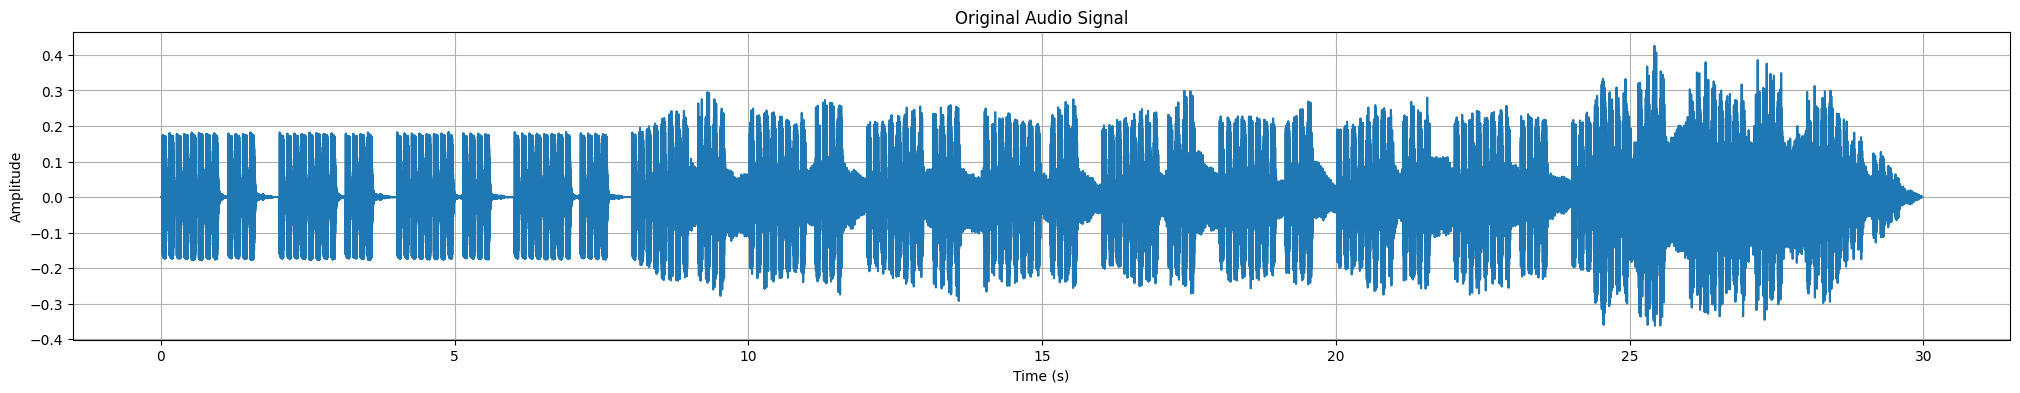

In [38]:
# main execution
file_path = "D://Abhinav//Test//SpeechProcessing//sample.wav"

# load and plot the orignal signal
original_audio, sr = load_audio(file_path)
plot_signal(original_audio, sr, title="Original Audio Signal")

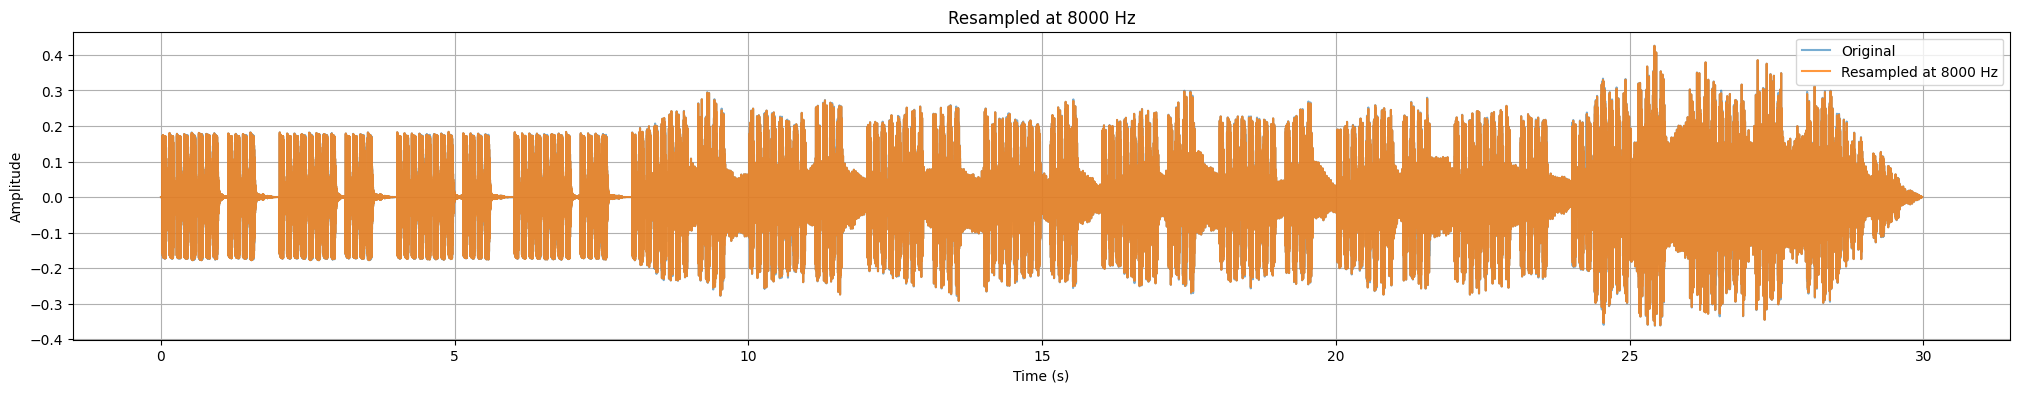

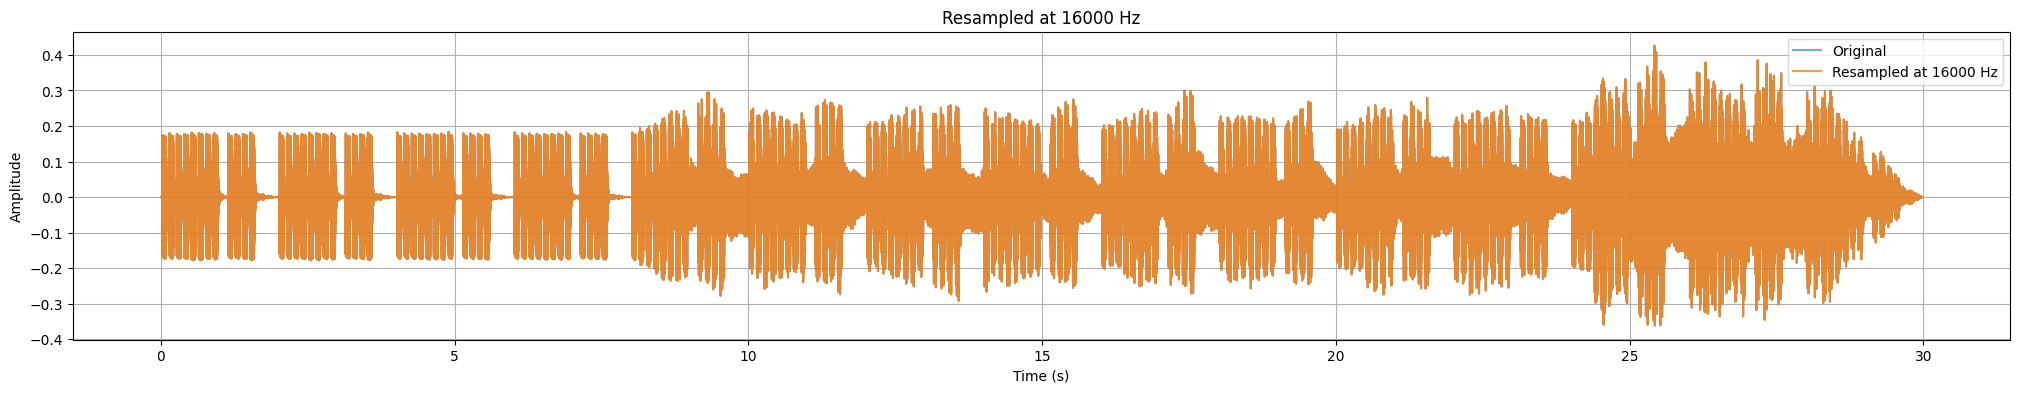

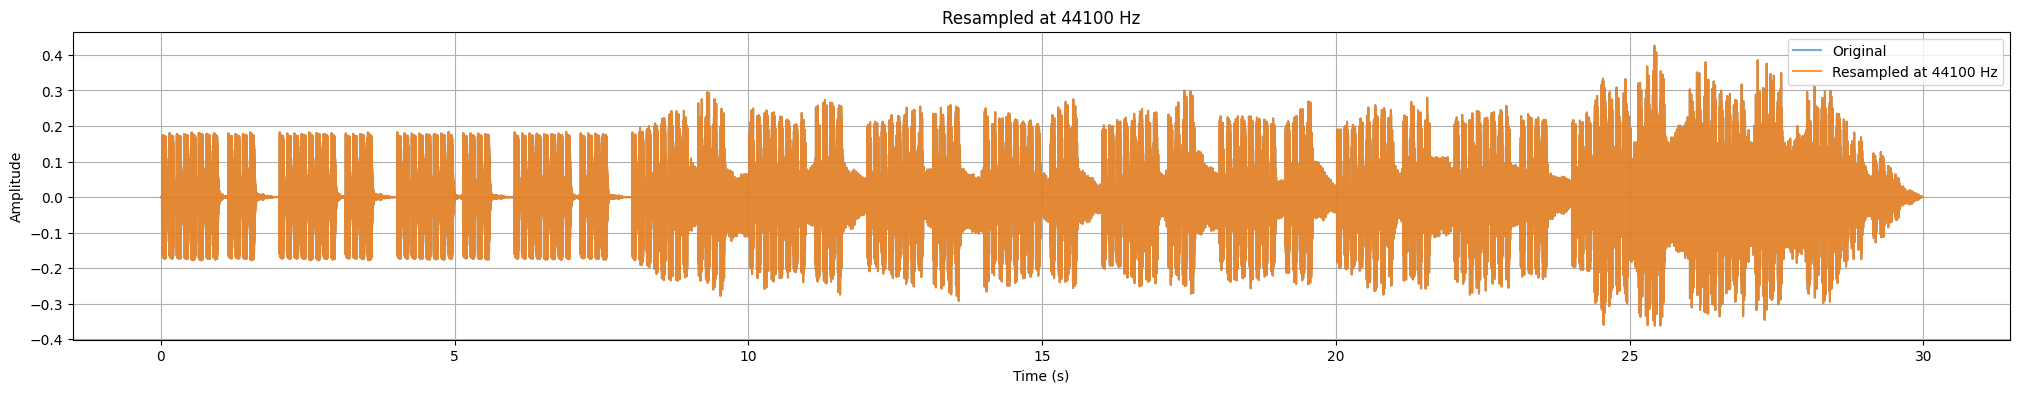

In [39]:
# resample at different rates
resample_rates = [8000, 16000, 44100]
resampled_signals = {}
resample_mse_results = {}

for rate in resample_rates:
    resampled_audio, new_sr = resample_signal(original_audio, sr, rate)
    resampled_signals[rate] = resampled_audio

    # calculate MSE between original and resampled signal (before reconstruction)
    resampled_audio_upsampled = signal.resample(resampled_audio, len(original_audio))
    resample_mse = calculate_mse(original_audio, resampled_audio_upsampled)
    resample_mse_results[rate] = resample_mse

    plot_resampled_signal(original_audio, sr, resampled_audio, new_sr, title=f"Resampled at {rate} Hz")

In [40]:
# display MSE for Original vs. Resampled Signals
print("\nMSE Between Original and Resampled Signals:")
for rate, mse_value in resample_mse_results.items():
    print(f"MSE for resampling at {rate} Hz (no reconstruction): {mse_value}")


MSE Between Original and Resampled Signals:
MSE for resampling at 8000 Hz (no reconstruction): 5.067323627372389e-08
MSE for resampling at 16000 Hz (no reconstruction): 3.9267941787102245e-08
MSE for resampling at 44100 Hz (no reconstruction): 3.898310321060307e-15


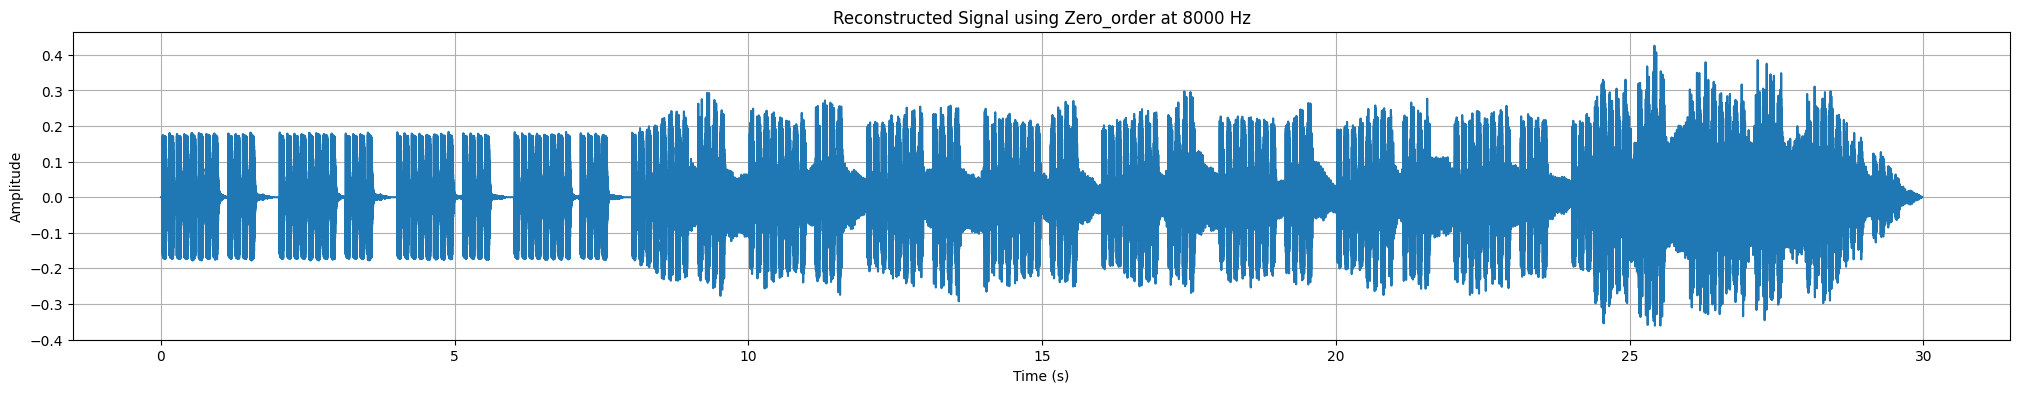

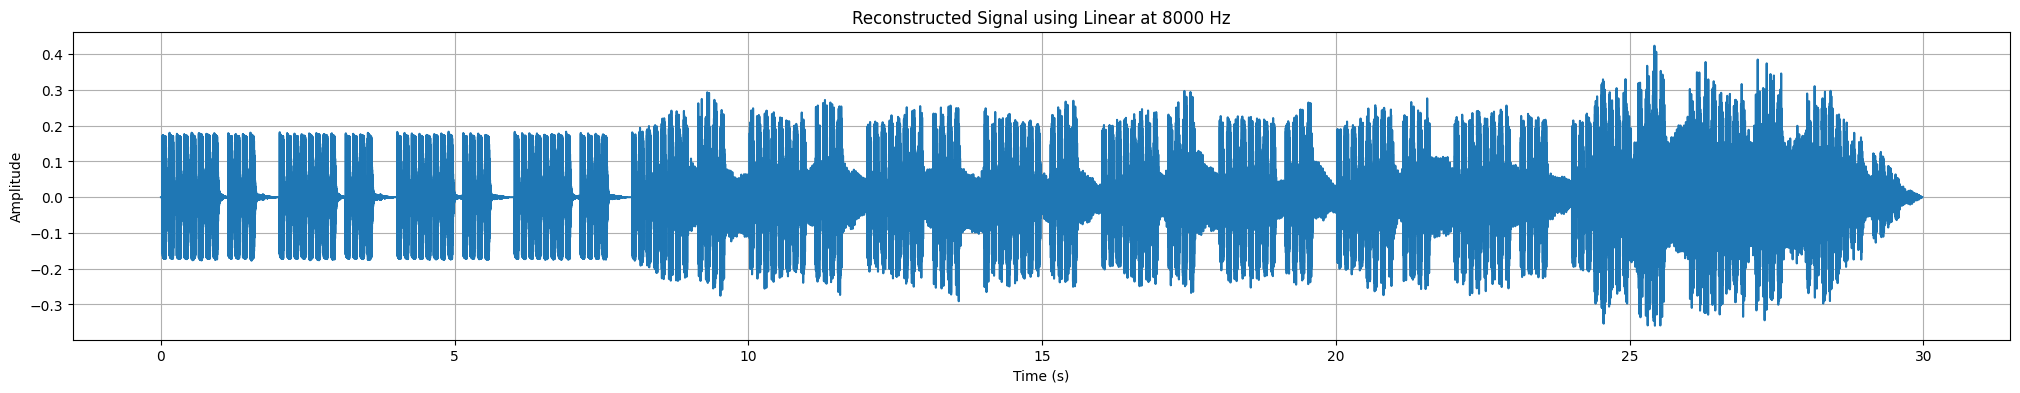

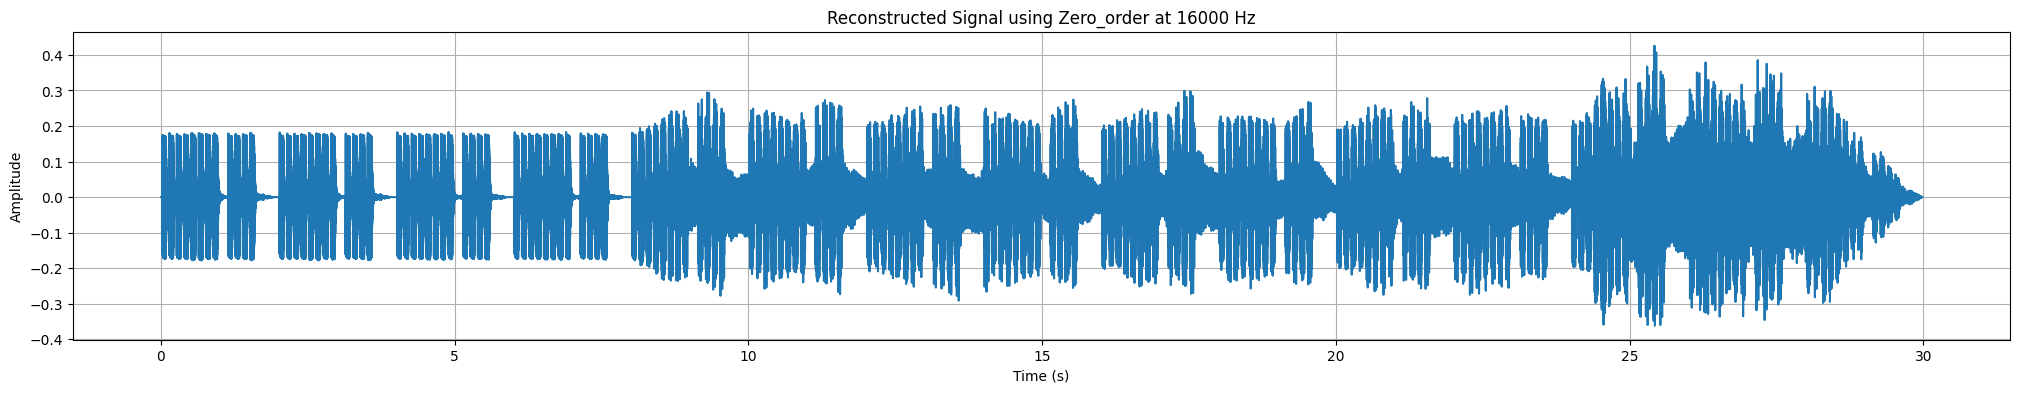

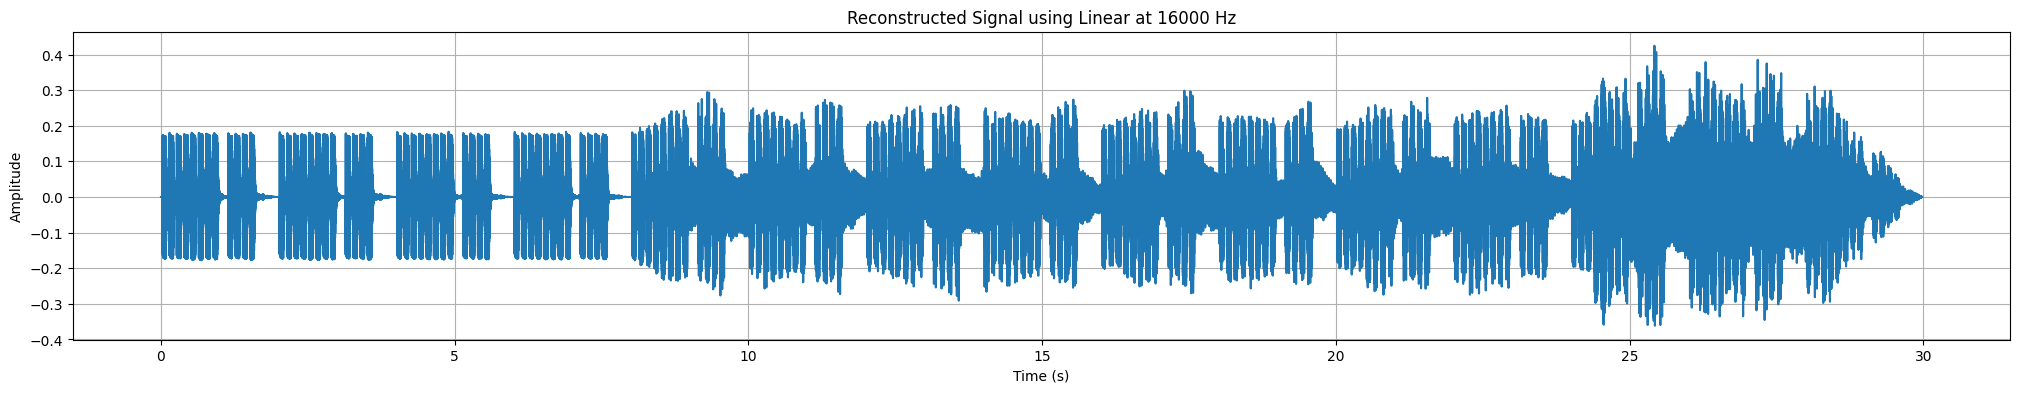

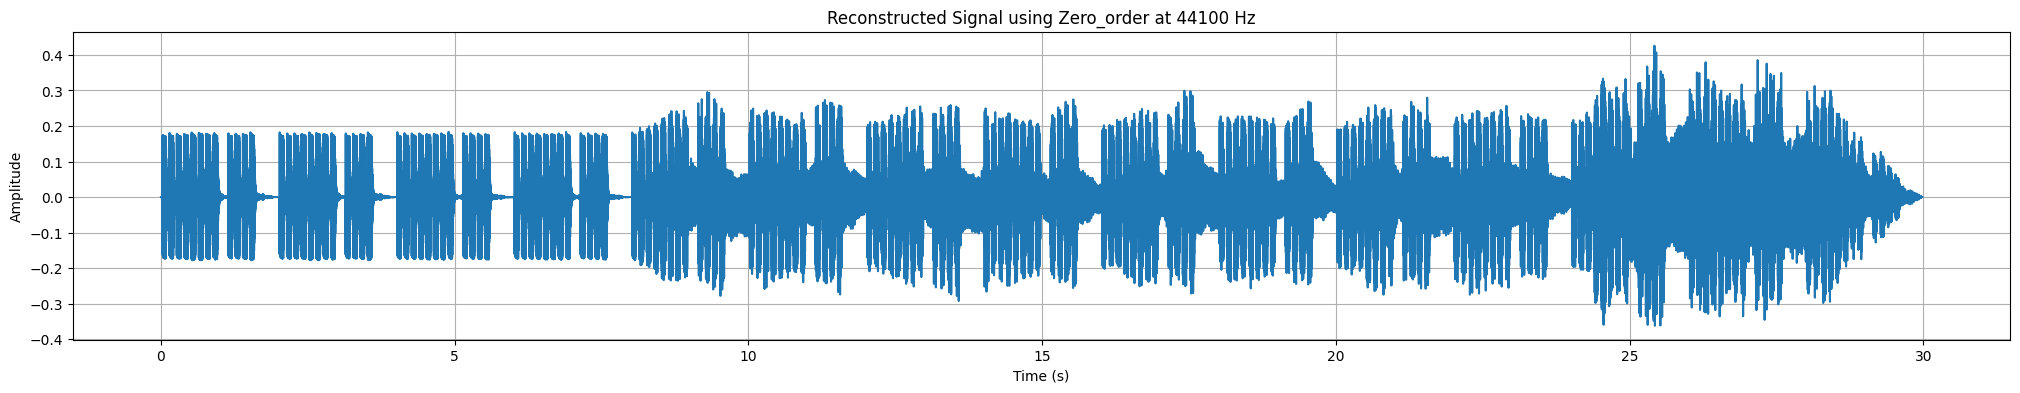

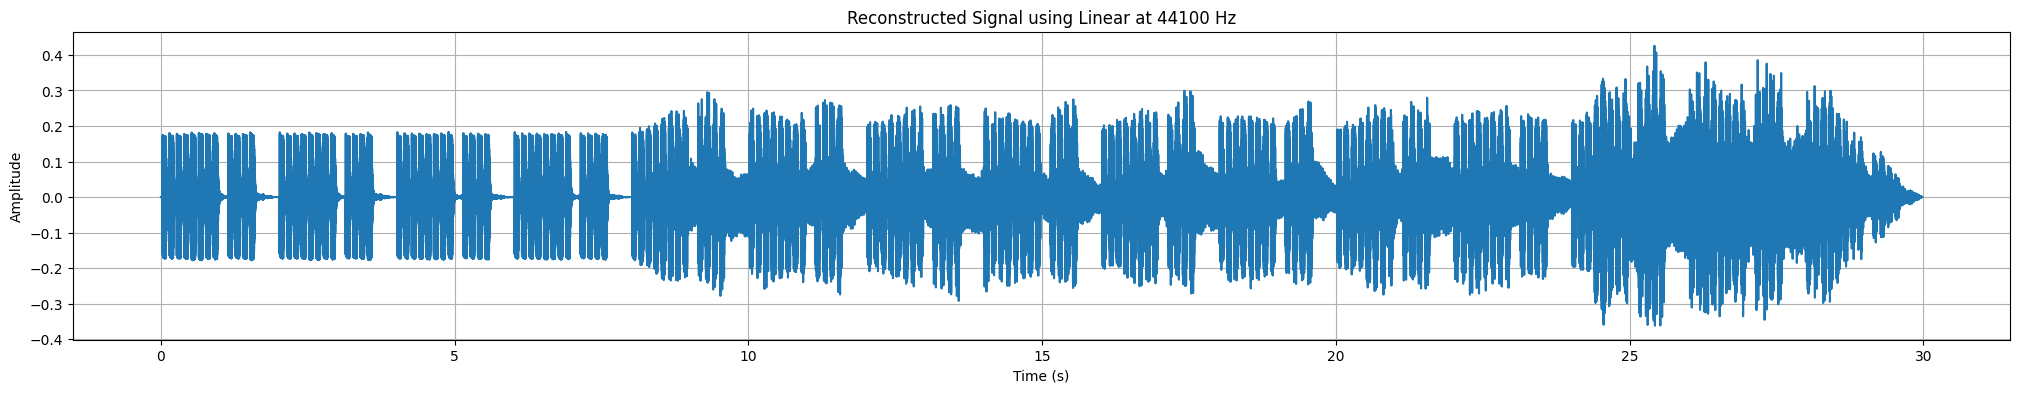

In [41]:
# reconstruct signals using Zero-Order Hold and Linear Interpolation
methods = ['zero_order', 'linear']
mse_results = {}

for rate, resampled_audio in resampled_signals.items():
    mse_results[rate] = {}
    for method in methods:
        reconstructed_audio = reconstruct_signal(original_audio, resampled_audio, sr, rate, method=method)
        mse = calculate_mse(original_audio, reconstructed_audio)
        mse_results[rate][method] = mse
        plot_signal(reconstructed_audio, sr, title=f"Reconstructed Signal using {method.capitalize()} at {rate} Hz")

In [42]:
# print MSE Results for Reconstructed Signals
print("\nMSE Between Original and Reconstructed Signals:")
for rate, method_results in mse_results.items():
    for method, mse_value in method_results.items():
        print(f"MSE for {method.capitalize()} interpolation at {rate} Hz: {mse_value}")


MSE Between Original and Reconstructed Signals:
MSE for Zero_order interpolation at 8000 Hz: 0.00029853067826479673
MSE for Linear interpolation at 8000 Hz: 0.0002102853666405714
MSE for Zero_order interpolation at 16000 Hz: 5.4441388783743605e-05
MSE for Linear interpolation at 16000 Hz: 3.2372393310951334e-05
MSE for Zero_order interpolation at 44100 Hz: 1.3349085724006084e-15
MSE for Linear interpolation at 44100 Hz: 1.334910612117885e-15


# Task 2: Source-Filter Model

In [43]:
# importing all the necessary packages
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import lfilter

In [44]:
# step 1: generate glottal pulse train (voiced) or white noise (unvoiced)
def generate_source_signal(length, sr, voiced=True, f0=100):
    if voiced:
        t = np.linspace(0, length, int(length * sr), endpoint=False)
        return np.sin(2 * np.pi * f0 * t)  # Simple glottal pulse train
    else:
        return np.random.randn(int(length * sr))  # White noise for unvoiced sounds


In [45]:
# step 2: apply a vocal tract filter (all-pole filter with formants)
def apply_vocal_tract_filter(source_signal, formants, bandwidths, sr):
    # Convert formants and bandwidths to poles
    poles = []
    for f, bw in zip(formants, bandwidths):
        r = np.exp(-np.pi * bw / sr)
        theta = 2 * np.pi * f / sr
        poles.append(r * np.exp(1j * theta))
        poles.append(r * np.exp(-1j * theta))
    
    # Convert poles to filter coefficients (denominator of transfer function)
    a = np.poly(poles)
    return lfilter([1], a, source_signal)

In [46]:
# step 3: plot generated speech signal
def plot_synthetic_signal(signal, sr, title="Generated Speech Signal"):
    time = np.linspace(0, len(signal) / sr, len(signal))
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [47]:
# main execution (source-filter model)
sr = 16000  # sampling rate
length = 1.0  # duration in seconds

In [48]:
# generate source signal (voiced with glottal pulse train)
source_signal = generate_source_signal(length, sr, voiced=True, f0=100)

In [49]:
# define formants (frequencies of resonances) and bandwidths
formants = [500, 1500, 2500]  # example formants for vowels
bandwidths = [60, 90, 120]    # bandwidths for formants

In [50]:
# apply vocal tract filter
filtered_signal = apply_vocal_tract_filter(source_signal, formants, bandwidths, sr)

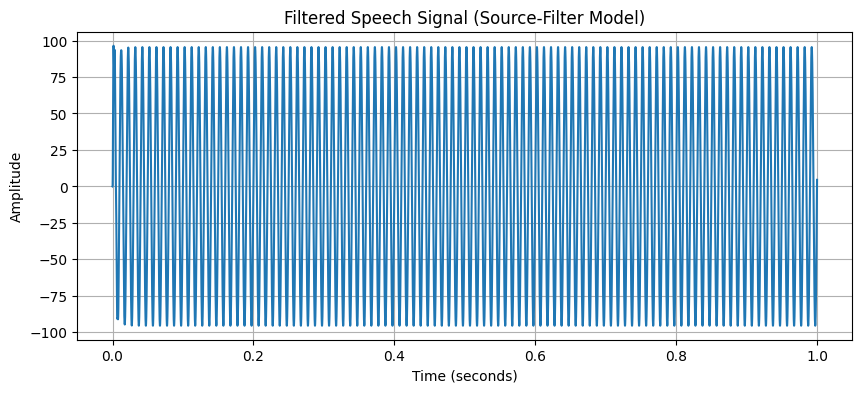

In [51]:
# plot generated speech signal
plot_synthetic_signal(filtered_signal, sr, title="Filtered Speech Signal (Source-Filter Model)")